In [73]:
import pandas as pd
import numpy as np
import pathlib
from tqdm.notebook import tqdm
import librosa
import awkward as ak
import matplotlib.pyplot as plt
from IPython.display import Audio 
from collections import defaultdict
from scipy.signal import decimate


from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

In [74]:
from scikitplot.metrics import plot_roc
# Print Roc Curve 
def print_rocCurve(clf,X_test,y_test):
    y_tmp=clf.predict_proba(X_test)
    plot_roc(y_test, clf.predict_proba(X_test),figsize=(10,6))
    plt.show()
    #print(roc_auc_score(y_test, y_tmp))
    #print(roc_auc_score(y_test, y_tmp[:,1]))

In [75]:
# Read the TS continous values
X_train = np.load("../../RavdessAudioOnlyNumpy__X_train.npy")
X_test = np.load("../../RavdessAudioOnlyNumpy__X_test.npy")
print(X_train.shape, X_test.shape)

(1828, 304304) (634, 304304)


In [76]:
# Individua le colonne con valori nulli
col_with_nulls = np.isnan(X_train).any(axis=0)

# Ottieni gli indici delle colonne con valori nulli
indices_with_nulls = np.where(col_with_nulls)[0]

X_train = np.delete(X_train, indices_with_nulls, axis=1)
X_test = np.delete(X_test, indices_with_nulls, axis=1)

In [77]:
df_Y_train=pd.read_csv('../../RavdessAudioOnlyNumpy__Y_train.csv')
df_Y_test=pd.read_csv('../../RavdessAudioOnlyNumpy__Y_test.csv')

In [78]:
#LabelEncode categorical features
from sklearn import preprocessing

le=preprocessing.LabelEncoder()
c = df_Y_train.select_dtypes(include=['object']).columns.tolist()
for i in c:
    df_Y_train[i]=le.fit_transform(df_Y_train[i])

for i in c:
    df_Y_test[i]=le.fit_transform(df_Y_test[i])

In [79]:
y_train=np.array(df_Y_train['vocal_channel'])
y_test=np.array(df_Y_test['vocal_channel'])

In [64]:
from tslearn.preprocessing import TimeSeriesScalerMinMax
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train).reshape(X_train.shape[0], X_train.shape[1])
X_test = scaler.fit_transform(X_test).reshape(X_test.shape[0], X_test.shape[1])

In [80]:
X_train.shape

(1828, 140941)

Approximation of time series

In [81]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation
from pyts.approximation import DiscreteFourierTransform

#n_paa_segments = 1000
#n_sax_symbols = 8
#sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
#ts_sax_X_train = sax.fit_transform(X_train)
#ts_sax_X_test = sax.fit_transform(X_test)

n_coefs = 1000

dft = DiscreteFourierTransform(n_coefs=n_coefs)
ts_dft_X_train = dft.fit_transform(X_train) 
ts_dft_X_test = dft.fit_transform(X_test) 

Shapelet Classifiers

In [82]:
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

In [83]:
ts_dft_X_train.shape

(1828, 1000)

In [84]:
n_ts, ts_sz = ts_dft_X_train.shape
n_classes = len(set(y_train))


# Set the number of shapelets per size 
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, # this function that take n. of TS, n. T stamps, number of classe, learnig rate an it returns a set of suggested sizes to look for the shapelets
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 1828
ts_sz 1000
n_classes 2
shapelet_sizes {100: 6}


In [85]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1)
shp_clf.fit(ts_dft_X_train, y_train)
y_pred = shp_clf.predict(ts_dft_X_test)
print(classification_report(y_test, y_pred))

d:\Anaconda\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/200
8/8 [==============================] - 1s 34ms/step - loss: 4623505.0000 - binary_accuracy: 0.5109 - binary_crossentropy: 4623184.0000
Epoch 2/200
8/8 [==============================] - 0s 31ms/step - loss: 3228741.7500 - binary_accuracy: 0.5033 - binary_crossentropy: 3228518.0000
Epoch 3/200
8/8 [==============================] - 0s 35ms/step - loss: 2014694.5000 - binary_accuracy: 0.5503 - binary_crossentropy: 2014534.0000
Epoch 4/200
8/8 [==============================] - 0s 32ms/step - loss: 1620583.6250 - binary_accuracy: 0.5088 - binary_crossentropy: 1620480.5000
Epoch 5/200
8/8 [==============================] - 0s 31ms/step - loss: 1344654.2500 - binary_accuracy: 0.4989 - binary_crossentropy: 1344527.0000
Epoch 6/200
8/8 [==============================] - 0s 36ms/step - loss: 1090186.6250 - binary_accuracy: 0.5088 - binary_crossentropy: 1090112.7500
Epoch 7/200
8/8 [==============================] - 0s 31ms/step - loss: 864242.8125 - binary_accuracy: 0.5317 - binary

d:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 24ms/step


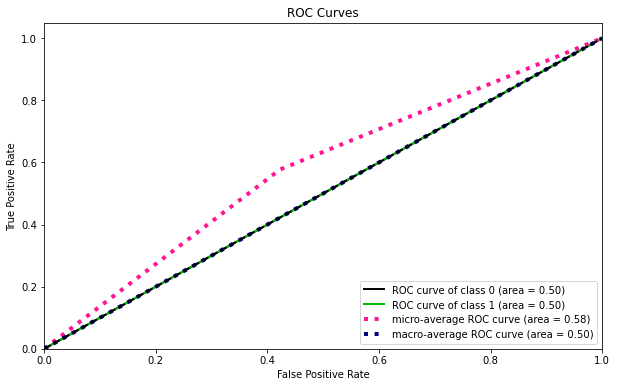

In [86]:
print_rocCurve(shp_clf,ts_dft_X_test,y_test)

Cerco di analizzare le 6 shapelts trovate

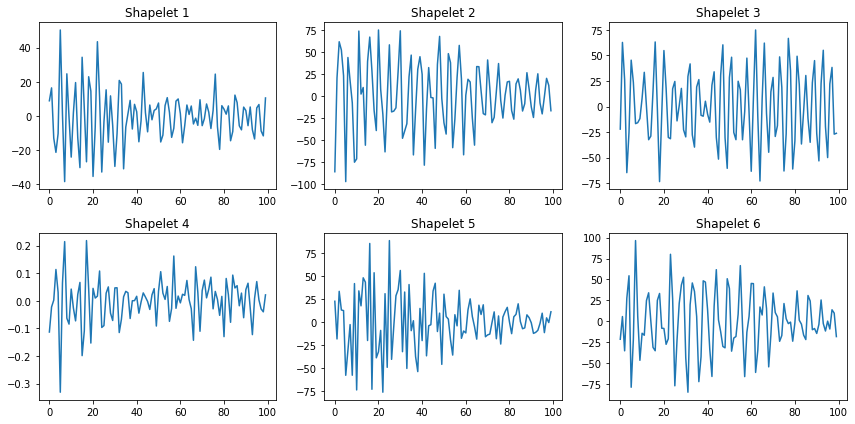

In [88]:
import matplotlib.pyplot as plt

# shapelets è una lista di array che rappresentano le shapelet estratte
shapelets = shp_clf.shapelets_ # Inserisci qui i tuoi dati delle shapelet

# Creazione di un subplot per ogni shapelet
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

# Iterazione attraverso le shapelet e il subplot corrispondente
for i, shapelet in enumerate(shapelets):
    row = i // 3
    col = i % 3
    ax = axs[row, col]

    # Tracciamento della shapelet come grafico a linee
    ax.plot(shapelet)

    # Aggiunta di etichette per il subplot
    ax.set_title(f"Shapelet {i+1}")

# Ottimizzazione dei layout e visualizzazione del grafico
plt.tight_layout()
plt.show()

# Shaplet-distances-based Classifier

In [89]:
from sklearn.neighbors import KNeighborsClassifier

X_train2 = shp_clf.transform(ts_dft_X_train) # we can also use the transform function that basically calculate the distance between the shapoelets found and a dataset of TS
X_test2 = shp_clf.transform(ts_dft_X_test)
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train2, y_train)
y_pred = clf.predict(X_test2)
print(classification_report(y_test, y_pred))

3/3 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       0.57      0.61      0.59       268
           1       0.70      0.66      0.68       366

    accuracy                           0.64       634
   macro avg       0.63      0.63      0.63       634
weighted avg       0.64      0.64      0.64       634



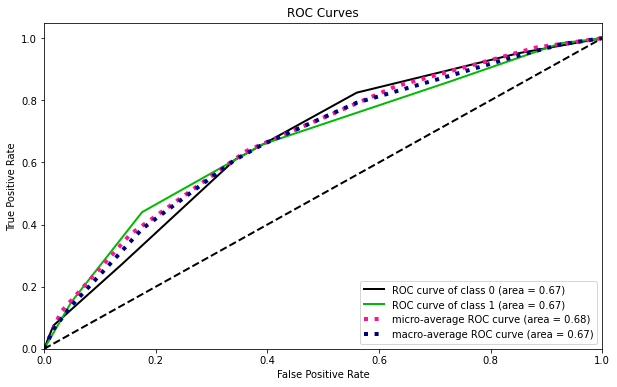

In [90]:
print_rocCurve(clf,X_test2,y_test)

In [91]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train2, y_train)
y_pred = clf.predict(X_test2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.68      0.68       268
           1       0.77      0.76      0.76       366

    accuracy                           0.73       634
   macro avg       0.72      0.72      0.72       634
weighted avg       0.73      0.73      0.73       634



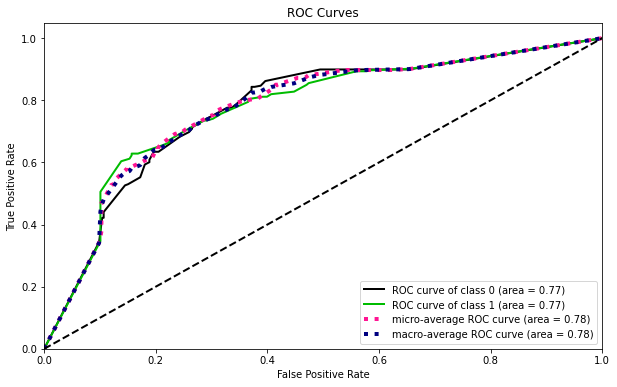

In [92]:
print_rocCurve(clf,X_test2,y_test)

In [93]:
clf.feature_importances_

array([0.09695543, 0.11844816, 0.11227855, 0.3105481 , 0.14088996,
       0.22087981])

In [63]:
ts_dft_X_train.shape

(1828, 1000)

Time Series Classifier

In [25]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
clf.fit(ts_dft_X_train, y_train)

y_pred = clf.predict(ts_dft_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71       268
           1       0.80      0.72      0.76       366

    accuracy                           0.74       634
   macro avg       0.74      0.74      0.74       634
weighted avg       0.75      0.74      0.74       634



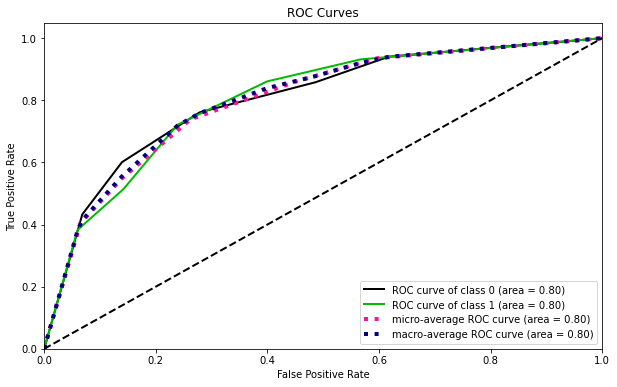

In [26]:
print_rocCurve(clf,ts_dft_X_test,y_test)

In [27]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
clf.fit(ts_dft_X_train, y_train)

y_pred = clf.predict(ts_dft_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.84      0.76       268
           1       0.86      0.74      0.80       366

    accuracy                           0.78       634
   macro avg       0.78      0.79      0.78       634
weighted avg       0.79      0.78      0.78       634



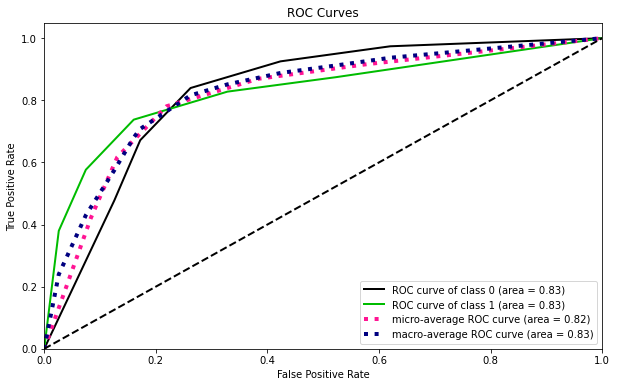

In [28]:
print_rocCurve(clf,ts_dft_X_test,y_test)

In [55]:
# TODO: da runnare
clf = KNeighborsTimeSeriesClassifier(distance='dtw')
clf.fit(ts_dft_X_train, y_train)
y_pred = clf.predict(ts_dft_X_test)
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

# CNN Classifier

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.layers import Conv1D, Activation, Conv1D, BatchNormalization

In [30]:
def build_simple_cnn(n_timesteps, n_outputs): # this is a CNN for this task
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [31]:
X_train_cnn = ts_dft_X_train.reshape((ts_dft_X_train.shape[0], ts_dft_X_train.shape[1], 1))
X_test_cnn = ts_dft_X_test.reshape((ts_dft_X_test.shape[0], ts_dft_X_test.shape[1], 1))

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  1000
N. LABELS:  2


In [32]:
cnn = build_simple_cnn(n_timesteps, n_outputs)
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 993, 16)           144       
                                                                 
 batch_normalization (BatchN  (None, 993, 16)          64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 993, 16)           0         
                                                                 
 dropout (Dropout)           (None, 993, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 989, 32)           2592      
                                                                 
 batch_normalization_1 (Batc  (None, 989, 32)          128       
 hNormalization)                                        

In [43]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))
history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/5
92/92 [==============================] - 2s 23ms/step - loss: 0.4715 - accuracy: 0.7839 - val_loss: 0.5414 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 2/5
92/92 [==============================] - 2s 22ms/step - loss: 0.4218 - accuracy: 0.8153 - val_loss: 0.4742 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 3/5
92/92 [==============================] - 2s 22ms/step - loss: 0.4160 - accuracy: 0.8222 - val_loss: 0.4336 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 4/5
92/92 [==============================] - 2s 23ms/step - loss: 0.3802 - accuracy: 0.8304 - val_loss: 0.3973 - val_accuracy: 0.8497 - lr: 0.0010
Epoch 5/5
92/92 [==============================] - 2s 22ms/step - loss: 0.3869 - accuracy: 0.8317 - val_loss: 0.3757 - val_accuracy: 0.8661 - lr: 0.0010


In [47]:
y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       268
           1       0.90      0.78      0.84       366

    accuracy                           0.82       634
   macro avg       0.82      0.83      0.82       634
weighted avg       0.84      0.82      0.83       634



Canonical Interval Forest(CIF)

In [53]:
from sktime.classification.interval_based import CanonicalIntervalForest

clf = CanonicalIntervalForest(n_estimators=30)
clf.fit(ts_dft_X_train, y_train)
y_pred = clf.predict(ts_dft_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       268
           1       0.94      0.87      0.91       366

    accuracy                           0.90       634
   macro avg       0.89      0.90      0.89       634
weighted avg       0.90      0.90      0.90       634



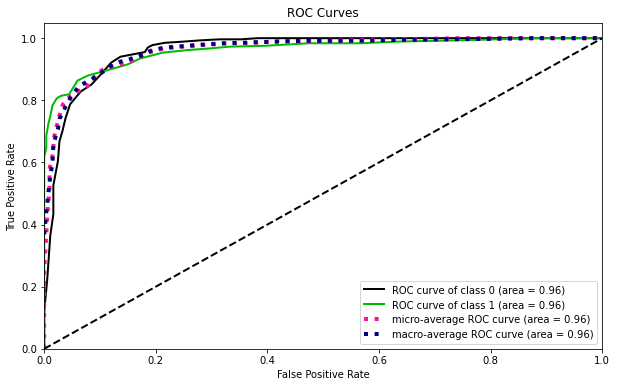

In [54]:
print_rocCurve(clf,ts_dft_X_test,y_test)